In [ ]:
# KEGG Pathway Analysis for Hypnoidus abbreviatus

In [1]:
# Import library
import pandas as pd

In [2]:
# Load eggNOG output (adjust the filename/path)
df = pd.read_csv("Haab_EggNOG_result.csv", low_memory=False)

In [3]:
df.head(2) # View top 2 columns from the dataframe

,#query,seed_ortholog,evalue,score,eggNOG_OGs,max_annot_lvl,COG_category,Description,Preferred_name,GOs,...,KEGG_ko,KEGG_Pathway,KEGG_Module,KEGG_Reaction,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs
0,Habb_00001.p1,7070.TC007466-PA,7.580000e-296,826.0,"COG1131@1|root,KOG0061@2759|Eukaryota,38CVQ@33...",33208|Metazoa,Q,ATP- binding,-,"GO:0003674,GO:0003824,GO:0005215,GO:0005319,GO...",...,-,-,-,-,-,-,-,-,-,"ABC2_membrane,ABC_tran"
1,Habb_00001.p3,7070.TC007466-PA,3.860000e-54,186.0,"COG1131@1|root,KOG0061@2759|Eukaryota,38CVQ@33...",33208|Metazoa,Q,ATP- binding,-,"GO:0003674,GO:0003824,GO:0005215,GO:0005319,GO...",...,-,-,-,-,-,-,-,-,-,ABC2_membrane


In [4]:
# Rename for consistency
df = df.rename(columns={"#query": "query"})

In [5]:
df = df[["query", "KEGG_ko"]]  # You can include 'KEGG_Pathway' if needed
df = df.dropna(subset=["KEGG_ko"])

In [6]:
len(df)

27624

In [7]:
import re

In [8]:
# clean up the query column by removing the version suffixes (.p1, .p2, .pe, etc.)
df["gene"] = df["query"].apply(lambda x: re.sub(r"\.p\d+$|\.pe$", "", x))

In [9]:
# Convert the KEGG_ko column to strings
# Creates a new column KEGG_ko_list by splitting the comma-separated values in KEGG_ko into lists
df["KEGG_ko"] = df["KEGG_ko"].astype(str)
df["KEGG_ko_list"] = df["KEGG_ko"].str.split(",")

In [10]:
# explodes the KEGG_ko_list column into separate rows
df_exploded = df.explode("KEGG_ko_list")
df_exploded = df_exploded[["gene", "KEGG_ko_list"]].rename(columns={"KEGG_ko_list": "kegg_id"})

In [11]:
df_exploded

,gene,kegg_id
0,Habb_00001,-
1,Habb_00001,-
2,Habb_00002,-
3,Habb_00006,ko:K10643
4,Habb_00007,ko:K10643
...,...,...
27620,Habb_99961,ko:K10703
27621,Habb_99973,ko:K11723
27621,Habb_99973,ko:K22184
27622,Habb_99975,ko:K04708


In [12]:
df_exploded = df_exploded[df_exploded['kegg_id'] != '-'] # Remove "-"

In [13]:
len(df_exploded) # length of dataframe

25470

In [14]:
df_exploded # View the dataframe

,gene,kegg_id
3,Habb_00006,ko:K10643
4,Habb_00007,ko:K10643
5,Habb_00012,ko:K01312
6,Habb_00013,ko:K09632
7,Habb_00018,ko:K08819
...,...,...
27620,Habb_99961,ko:K10703
27621,Habb_99973,ko:K11723
27621,Habb_99973,ko:K22184
27622,Habb_99975,ko:K04708


In [15]:
# Count KO frequencies

In [16]:
kegg_counts = df_exploded["kegg_id"].value_counts().reset_index()
kegg_counts.columns = ["kegg_id", "count"]

In [17]:
kegg_counts

,kegg_id,count
0,ko:K09228,159
1,ko:K12567,151
2,ko:K14999,143
3,ko:K00699,126
4,ko:K09640,120
...,...,...
6597,ko:K17433,1
6598,ko:K17386,1
6599,ko:K10687,1
6600,ko:K17353,1


In [18]:
# Remove "ko:" prefix from the KEGG ID to match ko_df
kegg_counts["kegg_id_clean"] = kegg_counts["kegg_id"].str.replace("ko:", "", regex=False)

In [19]:
kegg_counts.head(3)

,kegg_id,count,kegg_id_clean
0,ko:K09228,159,K09228
1,ko:K12567,151,K12567
2,ko:K14999,143,K14999


In [20]:
# Annotate KO terms

In [21]:
import requests

In [22]:
# Download KO names once from KEGG
#wget https://rest.kegg.jp/list/ko -O ko_list.txt

In [23]:
# Load KO descriptions, using multiple spaces as separator
ko_df = pd.read_csv("ko_list.txt", sep='\t', header=None, names=["kegg_id", "description"])

In [24]:
# Preview
ko_df.head()

,kegg_id,description
0,K00001,"E1.1.1.1, adh; alcohol dehydrogenase [EC:1.1.1.1]"
1,K00002,"AKR1A1, adh; alcohol dehydrogenase (NADP+) [EC..."
2,K00003,hom; homoserine dehydrogenase [EC:1.1.1.3]
3,K00004,"BDH, butB; (R,R)-butanediol dehydrogenase / me..."
4,K00005,gldA; glycerol dehydrogenase [EC:1.1.1.6]


In [25]:
# ko_df is already loaded with:
# Columns: ["kegg_id", "description"]
ko_map = dict(zip(ko_df["kegg_id"], ko_df["description"]))

In [26]:
# Add description by mapping cleaned KO ID
kegg_counts["description"] = kegg_counts["kegg_id_clean"].map(ko_map).fillna("Unknown")

In [27]:
kegg_counts.head(2)

,kegg_id,count,kegg_id_clean,description
0,ko:K09228,159,K09228,KRAB; KRAB domain-containing zinc finger protein
1,ko:K12567,151,K12567,TTN; titin [EC:2.7.11.1]


In [28]:
# Optional cleaning: Remove EC annotations
kegg_counts["description"] = kegg_counts["description"].str.replace(r"\s+\[EC:[^\]]+\]", "", regex=True)

In [29]:
kegg_counts

,kegg_id,count,kegg_id_clean,description
0,ko:K09228,159,K09228,KRAB; KRAB domain-containing zinc finger protein
1,ko:K12567,151,K12567,TTN; titin
2,ko:K14999,143,K14999,CYP6; cytochrome P450 family 6
3,ko:K00699,126,K00699,UGT; glucuronosyltransferase
4,ko:K09640,120,K09640,TMPRSS9; transmembrane protease serine 9
...,...,...,...,...
6597,ko:K17433,1,K17433,MRPL52; large subunit ribosomal protein L52
6598,ko:K17386,1,K17386,PDGFB; platelet-derived growth factor subunit B
6599,ko:K10687,1,K10687,UBE2F; ubiquitin-conjugating enzyme E2 F
6600,ko:K17353,1,K17353,TSPAN18; tetraspanin-18


In [30]:
# Filter Low-Frequency KOs (e.g., <20 occurrences)
filtered_kegg = kegg_counts[kegg_counts["count"] >= 10]

In [31]:
filtered_kegg

,kegg_id,count,kegg_id_clean,description
0,ko:K09228,159,K09228,KRAB; KRAB domain-containing zinc finger protein
1,ko:K12567,151,K12567,TTN; titin
2,ko:K14999,143,K14999,CYP6; cytochrome P450 family 6
3,ko:K00699,126,K00699,UGT; glucuronosyltransferase
4,ko:K09640,120,K09640,TMPRSS9; transmembrane protease serine 9
...,...,...,...,...
357,ko:K18266,10,K18266,NDRG1; protein NDRG1
358,ko:K12389,10,K12389,"BTS, CLN3; battenin"
359,ko:K19176,10,K19176,FAAH2; fatty acid amide hydrolase 2
360,ko:K08823,10,K08823,CLK2_3; dual specificity protein kinase CLK2/3


In [32]:
# Import libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
# Visualize top 20 KEGG pathways based on their 'count'
top_kegg = filtered_kegg.sort_values("count", ascending=False).head(20)

C:\Users\Staff\AppData\Local\Temp\ipykernel_2176\45982430.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


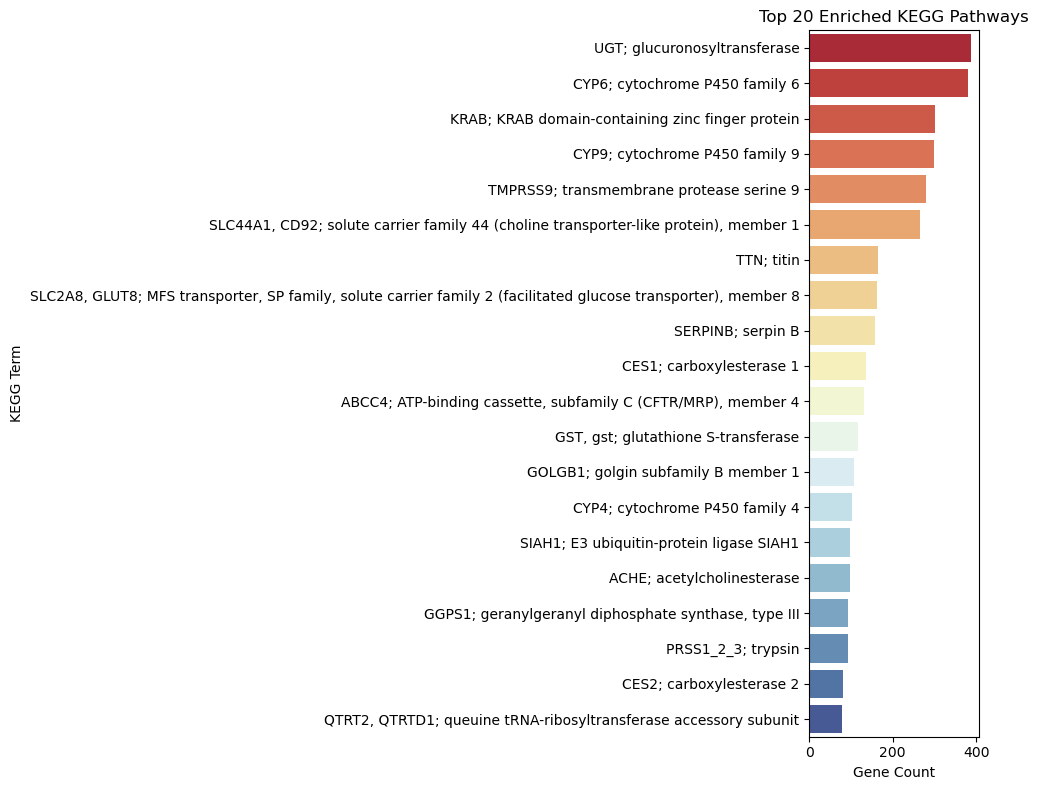

In [34]:
# Parameters for visualization
plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_kegg,
    y="description",
    x="count",
    palette="RdYlBu"
)
plt.title("Top 20 Enriched KEGG Pathways")
plt.xlabel("Gene Count")
plt.ylabel("KEGG Term")
plt.tight_layout()
plt.savefig("Lcal_KEGG_Enrichment.png", dpi=600)
plt.show()

In [35]:
# Save

In [32]:
filtered_kegg.to_csv("Habb_KEGG_Enrichment.csv", index=False)